# Main functions used in experiments

In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [2]:
from windy_gridworld import WindyGridworldEnv
from gridworld import GridworldEnv
# env = WindyGridworldEnv()
# env = GridworldEnv()
# env??
import gym
env = gym.envs.make("FrozenLake-v0")
env.env.__init__(is_slippery=False)

/Users/berend/miniconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
try:
    env.nA = env.env.nA
    env.nS = env.env.nS
except:
    pass

## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [4]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a greedy policy
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 

        best_action = np.random.choice(best_actions)
        
        return best_action

In [5]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a epsilon greedy policy
        """

        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
    

    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
         
        best_actions = [i for i, j in enumerate(self.Q[obs])
                   if j == np.max(self.Q[obs])] 

        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice(best_actions)
        else:
            action = np.random.randint(0,4)
                
        return action


# Monte Carlo

In [6]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [7]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.nS, env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 6


## Importance Sampling


In [93]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42, 
                           analyse_states=[(0,2), (0,1), (14,2), (2,1), (8,2)]):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.zeros((env.nS, env.nA))
    if weighted:
        C = np.zeros((env.nS, env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    
    # set seed
    np.random.seed(seed)
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * W * (G - Q[s][a])

            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break

        # store state values to analyse
        for (s,a) in analyse_states:
#             print(Q[s][a])
            analysis_values[(s,a)].append(Q[s][a])
            
    return Q, episode_lens, analysis_values

## Performance


In [9]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.1
gamma = 0.99
num_episodes = 5000
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths, mc_analysis_ordinary = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)

print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths, mc_analysis_weighted = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes)


100%|██████████| 5000/5000 [00:02<00:00, 1873.67it/s]


In [10]:
# check how long an episode takes under the found Q function
mc_greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
mc_greedy_weighted = GreedyPolicy(Q_mc_weighted)

mc_ordinary_episode = sample_episode(env, mc_greedy_ordinary)
mc_weighted_episode = sample_episode(env, mc_greedy_weighted)

print(f"resulting episode length ordinary: {len(mc_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(mc_weighted_episode[0])}")

resulting episode length ordinary: 6
resulting episode length weighted: 6


In [11]:
# print(np.var(weighted_analysis[(19,3)]))
# print(np.var(ordinary_analysis[(19,3)]))
# Q_mc_weighted[19][3]
print(Q_mc_ordinary)

[[0.80912016 0.80448274 0.95093783 0.75222419]
 [0.87885209 0.         0.96026478 0.90918201]
 [0.92117355 0.9701394  0.88580561 0.90830443]
 [0.95805236 0.         0.6088097  0.34997777]
 [0.12216707 0.88288204 0.         0.11072256]
 [0.         0.         0.         0.        ]
 [0.         0.98002116 0.         0.95800535]
 [0.         0.         0.         0.        ]
 [0.16267778 0.         0.94862805 0.161051  ]
 [0.30091874 0.94291205 0.98046848 0.        ]
 [0.91624516 0.98984639 0.         0.96853257]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.88881999 0.99035811 0.71920077]
 [0.97686216 0.9837277  1.         0.97746624]
 [0.         0.         0.         0.        ]]


In [12]:
env.reset()


0

### Plotting episode lengths during training

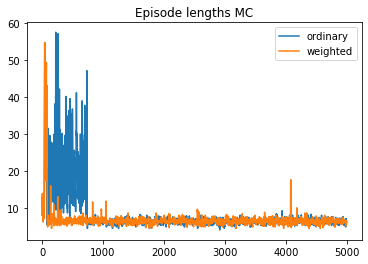

In [13]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 5

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

# Temporal Difference

### TO-DO: TD Ordinary Importance Sampling (make it work for gridworld)
Copied from TD_lab. Currently on-policy, needs to be off-policy.

Confused: do we need value functions instead of q-values? Do we even use importance weights in off-policy TD? Are there more off-policy TD methods besides SARSA?

### TO-DO: TD Weighted Importance Sampling (same as above but weighted)

In [14]:
## TD weighted importance sampling

In [94]:
import math

def sarsa_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, 
                                       discount_factor=1.0, alpha=0.5, seed=42,
                                 analyse_states=[(0,2), (0,1), (14,2), (2,1), (8,2)]):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        target policy: A policy which allows us to sample actions with its sample_action method.
        behaviour policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    np.random.seed(seed)
    
    # Keep track of useful statistics
    stats = []
    
#     Q = np.ones((env.nS, env.nA)) * -100
    Q = np.zeros((env.nS, env.nA))
    C = np.zeros((env.nS, env.nA))
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    for i_episode in tqdm(range(num_episodes), position=0):
        i = 0
        R = 0
        W = 1
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)                       
            
            W = (target_policy.get_probs(s_prime,a_prime))/(behavior_policy.get_probs(s_prime,a_prime))
            
            if W == 0:
                break
            
            if weighted:
                # Update weight and C
                C[s][a] = W
                # importance weight is 1 
                Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
            else:
                Q[s][a] += W * alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
                
            behavior_policy.Q[s][a] = Q[s][a]
            target_policy.Q[s][a] = Q[s][a]
            
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            if final_state:
                break
            
        stats.append((i, R))

        # store state values to analyse
        for (s,a) in analyse_states:
            analysis_values[(s,a)].append(Q[s][a])
    
    episode_lengths, episode_returns = zip(*stats)
    
    return Q, episode_lengths, analysis_values

In [95]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.1
gamma = 0.99
num_episodes = 5000
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_sarsa_ordinary, sarsa_ordinary_epslengths, sarsa_analysis_ordinary = sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,
                                                                         discount_factor=gamma, seed=seed)

Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)


print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_sarsa_weighted, sarsa_weighted_epslengths, sarsa_analysis_weighted = sarsa_importance_sampling(env, 
                                                                        behavioral_policy, target_policy,
                                                                        num_episodes, weighted=True,
                                                                        discount_factor=gamma, seed=seed)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes)


100%|██████████| 5000/5000 [00:02<00:00, 1821.29it/s]


In [17]:
# check how long an episode takes under the found Q function
sarsa_greedy_ordinary = GreedyPolicy(Q_sarsa_ordinary)
sarsa_greedy_weighted = GreedyPolicy(Q_sarsa_weighted)

sarsa_ordinary_episode = sample_episode(env, sarsa_greedy_ordinary)
sarsa_weighted_episode = sample_episode(env, sarsa_greedy_weighted)

print(f"resulting episode length ordinary: {len(sarsa_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(sarsa_weighted_episode[0])}")

resulting episode length ordinary: 6
resulting episode length weighted: 6


## Experiments

In [18]:
sarsa_analysis_weighted.keys()

dict_keys([(0, 2), (0, 1), (14, 2), (2, 1)])

In [19]:
def plot_values(state, action):
    plt.plot(np.arange(0,5000), sarsa_analysis_weighted[(state,action)], label='weighted', alpha=0.5)
    plt.plot(np.arange(0,5000), sarsa_analysis_ordinary[(state,action)], label='ordinary', alpha=0.5)
    plt.legend()
    plt.title(f"Values of Q({state},{action}) over episodes TD")
    plt.show()
    
    plt.plot(np.arange(0,5000), mc_analysis_weighted[(state,action)], label='weighted', alpha=0.5)
    plt.plot(np.arange(0,5000), mc_analysis_ordinary[(state,action)], label='ordinary', alpha=0.5)
    plt.legend()
    plt.title(f"Values of Q({state},{action}) over episodes MC")
    plt.show()

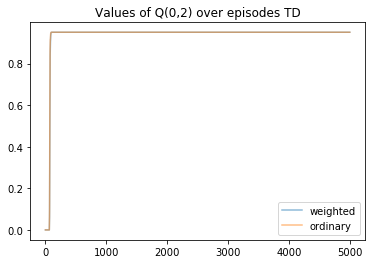

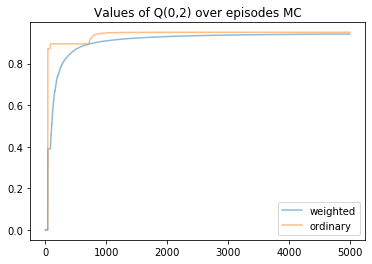

In [20]:
plot_values(0,2)

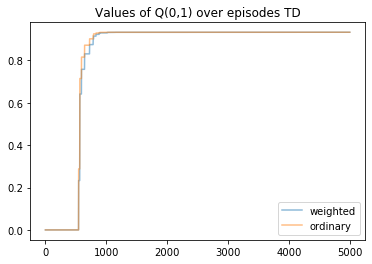

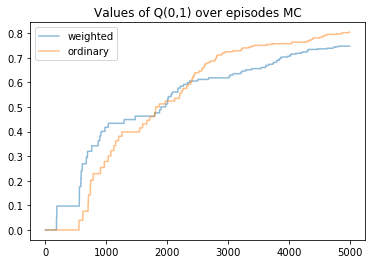

In [21]:
plot_values(0,1)

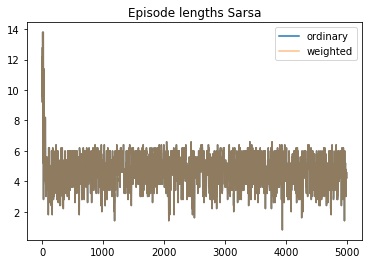

In [22]:
# set smoothing factor
n = 5

plt.plot(running_mean(sarsa_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(sarsa_weighted_epslengths, n), label="weighted", alpha=0.5)
# plt.hlines(num_episodes)
plt.title('Episode lengths Sarsa')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

In [23]:
sarsa_ordinary_epslengths

(22,
 6,
 3,
 23,
 4,
 12,
 14,
 8,
 8,
 10,
 24,
 5,
 19,
 11,
 6,
 5,
 8,
 5,
 3,
 5,
 26,
 2,
 33,
 3,
 5,
 2,
 2,
 2,
 18,
 16,
 6,
 13,
 4,
 12,
 4,
 6,
 9,
 9,
 5,
 5,
 2,
 11,
 2,
 11,
 4,
 3,
 2,
 6,
 6,
 3,
 3,
 14,
 2,
 5,
 2,
 13,
 15,
 6,
 2,
 4,
 2,
 5,
 6,
 2,
 6,
 1,
 6,
 0,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 2,
 6,
 2,
 1,
 6,
 6,
 2,
 6,
 6,
 3,
 6,
 6,
 0,
 6,
 1,
 6,
 6,
 2,
 6,
 3,
 6,
 2,
 4,
 6,
 6,
 6,
 6,
 0,
 0,
 6,
 2,
 1,
 2,
 6,
 6,
 6,
 7,
 6,
 0,
 6,
 4,
 2,
 2,
 6,
 6,
 6,
 6,
 7,
 4,
 2,
 4,
 6,
 6,
 6,
 1,
 0,
 3,
 4,
 6,
 0,
 3,
 0,
 6,
 6,
 2,
 6,
 1,
 6,
 6,
 6,
 0,
 6,
 0,
 4,
 6,
 1,
 6,
 1,
 0,
 4,
 2,
 6,
 6,
 6,
 6,
 6,
 3,
 6,
 6,
 6,
 6,
 0,
 6,
 1,
 1,
 1,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 4,
 1,
 6,
 6,
 3,
 0,
 6,
 3,
 3,
 2,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 2,
 1,
 4,
 2,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 1,
 3,
 3,
 6,
 3,
 6,
 6,
 6,
 1,
 6,
 7,
 3,
 6,
 6,
 1,
 3,
 6,
 6,
 1,
 6,
 6,
 8,
 6,
 6,
 2,
 7,
 6,
 0,
 6,
 6,
 6,
 2,
 0,
 6,
 6,
 

In [24]:
sarsa_weighted_epslengths == sarsa_ordinary_epslengths

True

## Variances

### MC

In [103]:
seeds = [42, 5, 20, 25, 30, 29, 23, 15, 13]
def run_seeds_mc(seeds):

        
    # set other parameters
    epsilon = 0.1
    gamma = 0.99
    num_episodes = 5000
        
    QS_mc_ordinary = np.zeros((len(seeds),env.nS, env.nA))    
    QS_mc_weighted = np.zeros((len(seeds),env.nS, env.nA))    
    
    mc_ordinary_ep_lens_all_seeds = np.zeros((len(seeds),num_episodes))
    mc_weighted_ep_lens_all_seeds = np.zeros((len(seeds),num_episodes))
    
    mc_q_ordinary_over_time_all_seeds = []
    mc_q_weighted_over_time_all_seeds = []
    
    for r,seed in enumerate(seeds):
        # Reproducible
        print(f"Seed: {seed}")
        seed = seed

        Q = np.zeros((env.nS, env.nA))
        behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
        target_policy = GreedyPolicy(Q)

        # the episode length is equal to the negative return. 
        print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes), seed {seed}")
        Q_mc_ordinary, mc_ordinary_epslengths, mc_analysis_ordinary = mc_importance_sampling(env,
                                                                       behavioral_policy, target_policy, 
                                                                       num_episodes, weighted=False,discount_factor=gamma, 
                                                                       epsilon=epsilon, seed=seed)
        QS_mc_ordinary[r] = Q_mc_ordinary
        mc_q_ordinary_over_time_all_seeds.append(mc_analysis_ordinary)
        mc_ordinary_ep_lens_all_seeds[r] = mc_ordinary_epslengths
        
        
        print(f"Updating Q using weighted importance sampling ({num_episodes} episodes), seed {seed}")
        Q_mc_weighted, mc_weighted_epslengths, mc_analysis_weighted = mc_importance_sampling(env,
                                                                       behavioral_policy, target_policy,
                                                                       num_episodes, weighted=True, discount_factor=gamma, 
                                                                       epsilon=epsilon, seed=seed)
        QS_mc_weighted[r] = Q_mc_weighted
        mc_q_weighted_over_time_all_seeds.append(mc_analysis_weighted)
        mc_weighted_ep_lens_all_seeds[r] = mc_weighted_epslengths
        
        # check how long an episode takes under the found Q function
        mc_greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
        mc_greedy_weighted = GreedyPolicy(Q_mc_weighted)

        mc_ordinary_episode = sample_episode(env, mc_greedy_ordinary)
        mc_weighted_episode = sample_episode(env, mc_greedy_weighted)

        print(f"Seed {seed}: resulting episode length ordinary: {len(mc_ordinary_episode[0])}")
        print(f"Seed {seed}: resulting episode length weighted: {len(mc_weighted_episode[0])}")
    
    return mc_q_ordinary_over_time_all_seeds, mc_q_weighted_over_time_all_seeds

In [104]:
mcqo, mcqw = run_seeds_mc(seeds)

  0%|          | 0/5000 [00:00<?, ?it/s]

Seed: 42
Updating Q using ordinary importance sampling (5000 episodes), seed 42


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 42


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 42: resulting episode length ordinary: 6
Seed 42: resulting episode length weighted: 6
Seed: 5
Updating Q using ordinary importance sampling (5000 episodes), seed 5


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 5


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 5: resulting episode length ordinary: 6
Seed 5: resulting episode length weighted: 6
Seed: 20
Updating Q using ordinary importance sampling (5000 episodes), seed 20


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 20


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 20: resulting episode length ordinary: 6
Seed 20: resulting episode length weighted: 6
Seed: 25
Updating Q using ordinary importance sampling (5000 episodes), seed 25


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 25


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 25: resulting episode length ordinary: 6
Seed 25: resulting episode length weighted: 6
Seed: 30
Updating Q using ordinary importance sampling (5000 episodes), seed 30


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 30


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 30: resulting episode length ordinary: 6
Seed 30: resulting episode length weighted: 6
Seed: 29
Updating Q using ordinary importance sampling (5000 episodes), seed 29


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 29


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 29: resulting episode length ordinary: 6
Seed 29: resulting episode length weighted: 6
Seed: 23
Updating Q using ordinary importance sampling (5000 episodes), seed 23


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 23


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 23: resulting episode length ordinary: 6
Seed 23: resulting episode length weighted: 6
Seed: 15
Updating Q using ordinary importance sampling (5000 episodes), seed 15


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 15


  0%|          | 0/5000 [00:00<?, ?it/s]

Seed 15: resulting episode length ordinary: 6
Seed 15: resulting episode length weighted: 6
Seed: 13
Updating Q using ordinary importance sampling (5000 episodes), seed 13


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes), seed 13


100%|██████████| 5000/5000 [00:02<00:00, 1815.71it/s]

Seed 13: resulting episode length ordinary: 6
Seed 13: resulting episode length weighted: 6


In [112]:
def plot_values_over_time(ordinary_list_of_dicts, weighted_list_of_dicts, seeds):
    
    n_seeds = len(seeds)
    
    n_states = len(ordinary_list_of_dicts[0])
    
    fig, axs = plt.subplots(n_states,2, figsize=(15,20))
    lspace = np.arange(0,5000)

    for i in range(len(ordinary_list_of_dicts)):
        for j, (k,vals) in enumerate(ordinary_list_of_dicts[i].items()):
            axs[j,0].plot(lspace, vals, label=f"Q({k[0]},{k[1]}), seed {i}")
            axs[j,1].plot(lspace, weighted_list_of_dicts[i][k], label=f"Q({k[0]},{k[1]}), seed {i}")
            
    for j in range(n_states):
        state_names = list(ordinary_list_of_dicts[0].keys())
#         axs[j,0].legend()
        axs[j,0].set_title(f"Q-values over episodes ordinary sampling, (state,action)={state_names[j]}")
#         axs[j,1].legend()
        axs[j,1].set_title(f"Q-values over episodes weighted sampling, (state,action)={state_names[j]}")


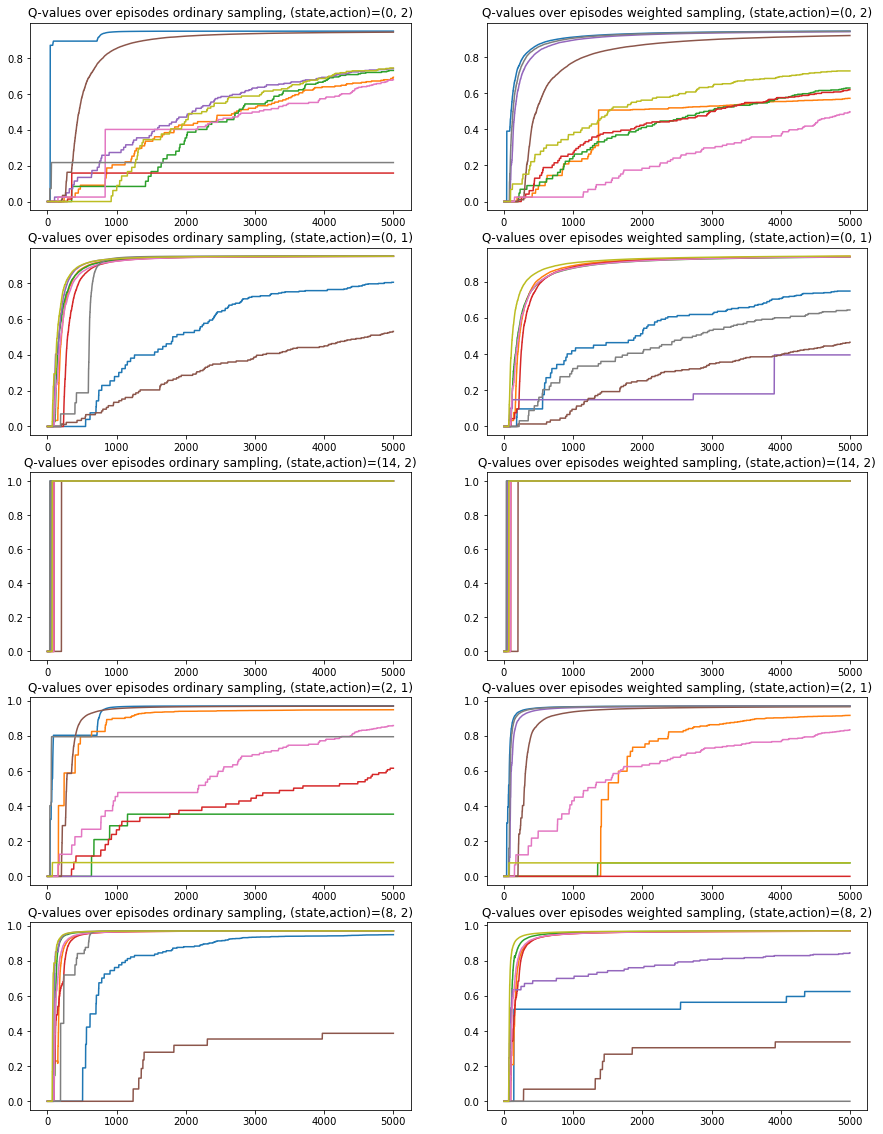

In [113]:
plot_values_over_time(mcqo, mcqw, seeds)